In [1]:
from __future__ import division, print_function
%matplotlib inline
from importlib import reload  # Python 3
import utils; reload(utils)
from utils import *
from keras.layers.merge import dot, add, concatenate

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
Using TensorFlow backend.


In [2]:
#path = "data/ml-latest-small/"  # from https://grouplens.org/datasets/movielens/
#path = "data/ml-20m/"
path = "datas/movielens/" #from https://github.com/ChicagoBoothML/DATA___MovieLens___20M
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

batch_size=64
#batch_size=1

In [3]:
#20M dataset
#ratings = pd.read_csv(path+'ratings.csv')

#2M dataset
ratings = pd.read_csv(path+'ratings01.csv')

#100k dataset
#ratings = pd.read_csv(path+'ratings100k.csv')

In [4]:
#show 5 first file rows
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
#nb of lines
len(ratings)

2000000

## datas prep
1. read files : ratings + movies
1. get list of unique items in ratings : users ID & movies ID
1. reorder users ID & movies ID to have countinuous integer items

In [6]:
#read film names
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict

#https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_dict.html
#https://stackoverflow.com/questions/30060616/python-pandas-to-dict-function

In [7]:
movie_names1 = pd.read_csv(path+'movies.csv').set_index('movieId')['title']
print(movie_names1[:5])

movieId
1                      Toy Story (1995)
2                        Jumanji (1995)
3               Grumpier Old Men (1995)
4              Waiting to Exhale (1995)
5    Father of the Bride Part II (1995)
Name: title, dtype: object


In [8]:
movie_names2 = pd.read_csv(path+'movies.csv').set_index('movieId')
print(movie_names2[:5])

                                      title  \
movieId                                       
1                          Toy Story (1995)   
2                            Jumanji (1995)   
3                   Grumpier Old Men (1995)   
4                  Waiting to Exhale (1995)   
5        Father of the Bride Part II (1995)   

                                              genres  
movieId                                               
1        Adventure|Animation|Children|Comedy|Fantasy  
2                         Adventure|Children|Fantasy  
3                                     Comedy|Romance  
4                               Comedy|Drama|Romance  
5                                             Comedy  


In [9]:
usersUniq = ratings.userId.unique()
moviesUniq = ratings.movieId.unique()

print(usersUniq[:20])
print(moviesUniq[:20])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[  2  29  32  47  50 112 151 223 253 260 293 296 318 337 367 541 589 593 653 919]


In [10]:
# userId and movieId become ditionary elements with values ranging from 0 to max len 
userUniqID2idx = {userID:index for index,userID in enumerate(usersUniq)}
movieUniqID2idx = {movieID:index for index,movieID in enumerate(moviesUniq)}

In [11]:
{movieID : movieUniqID2idx[movieID] for movieID in list(movieUniqID2idx)[:10]}

{1: 227,
 2: 0,
 3: 175,
 4: 1994,
 5: 1044,
 6: 364,
 7: 420,
 8: 1965,
 9: 1677,
 10: 365}

In [12]:
ratings.movieId[:20]

0       2
1      29
2      32
3      47
4      50
5     112
6     151
7     223
8     253
9     260
10    293
11    296
12    318
13    337
14    367
15    541
16    589
17    593
18    653
19    919
Name: movieId, dtype: int64

In [13]:
#We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.
ratings.movieId = ratings.movieId.apply(lambda x: movieUniqID2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userUniqID2idx[x])

#https://chrisalbon.com/python/data_wrangling/pandas_apply_operations_to_dataframes/

In [14]:
ratings.movieId[:15]

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
Name: movieId, dtype: int64

In [15]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())

In [16]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()

In [17]:
user_min, user_max, movie_min, movie_max, n_users, n_movies

(0, 13566, 0, 16714, 13567, 16715)

### embeddings

In [18]:
#number of latent factors in each embedding
n_factors = 50

In [19]:
np.random.seed = 42

#https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.seed.html

In [20]:
#Randomly split into training and validation

#Create an array of the given shape and populate it with random samples from a uniform distribution over [0, 1).
msk = np.random.rand(len(ratings)) < 0.8
print(msk)

trn = ratings[msk]
val = ratings[~msk]

[ True  True  True ...,  True  True  True]


In [21]:
trn[:5]

,userId,movieId,rating,timestamp
0,0,0,3.5,1112486027
1,0,1,3.5,1112484676
2,0,2,3.5,1112484819
3,0,3,3.5,1112484727
4,0,4,3.5,1112484580


In [22]:
val[:5]

,userId,movieId,rating,timestamp
6,0,6,4.0,1094785734
8,0,8,4.0,1112484940
10,0,10,4.0,1112484703
16,0,16,3.5,1112485557
20,0,20,3.5,1094785598


### Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [23]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(input_dim=n_in, output_dim=n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [24]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [25]:
x = concatenate([u, m], axis=2)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [26]:
nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         678350      user_in[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         835750      movie_in[0][0]                   
___________________________________________________________________________________________

In [27]:
x = dot([u, m], axes=2)
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [28]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         678350      user_in[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         835750      movie_in[0][0]                   
___________________________________________________________________________________________

In [26]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 1598441 samples, validate on 401559 samples
Epoch 1/8
1598441/1598441 [==============================] - 215s - loss: 1.0819 - val_loss: 0.8723
Epoch 2/8
1598441/1598441 [==============================] - 216s - loss: 0.9048 - val_loss: 0.8676
Epoch 3/8
1598441/1598441 [==============================] - 218s - loss: 0.9006 - val_loss: 0.8576
Epoch 4/8
1598441/1598441 [==============================] - 217s - loss: 0.8980 - val_loss: 0.8531
Epoch 5/8
1598441/1598441 [==============================] - 217s - loss: 0.8966 - val_loss: 0.8517
Epoch 6/8
1598441/1598441 [==============================] - 217s - loss: 0.8956 - val_loss: 0.8516
Epoch 7/8
1598441/1598441 [==============================] - 217s - loss: 0.8958 - val_loss: 0.8543
Epoch 8/8
1598441/1598441 [==============================] - 217s - loss: 0.8957 - val_loss: 0.8517


In [28]:
nn.save_weights(model_path+'NeuralNet2M.h5')

In [29]:
val.loc[(ratings['userId'] == 10) & (ratings['movieId'] < 500)]

,userId,movieId,rating,timestamp
979,10,8,4.5,1230858996
984,10,233,3.5,1230788496
997,10,182,5.0,1230788713
999,10,378,1.0,1230787591
1013,10,408,3.5,1230858873
1014,10,240,4.0,1230853952
1019,10,18,4.5,1251143205
1025,10,242,5.0,1230788340
1040,10,27,4.5,1230788620
1044,10,30,5.0,1230787560


In [30]:
nn.predict([np.array([10]), np.array([182])])

array([[ 3.8571]], dtype=float32)

In [31]:
nn.predict([np.array([10]), np.array([378])])

array([[ 3.1541]], dtype=float32)

In [34]:
trn.loc[(ratings['userId'] == 10) & (ratings['movieId'] < 50)]

,userId,movieId,rating,timestamp
963,10,2,5.0,1230783095
981,10,9,5.0,1230787560
983,10,11,3.5,1230858799
985,10,12,5.0,1230850571
989,10,14,4.0,1230858954
1002,10,15,4.5,1230787503
1008,10,16,4.5,1230788848
1010,10,17,5.0,1230858809
1034,10,22,4.0,1230859011
1041,10,28,4.5,1230853691


In [36]:
nn.predict([np.array([10]), np.array([36])])

array([[ 4.071]], dtype=float32)

In [37]:
nn.predict([np.array([10]), np.array([2])])

array([[ 3.9164]], dtype=float32)

In [41]:
g=ratings.groupby('movieId')['rating'].count()
allMovies=g.sort_values(ascending=False)[:]
allMovies = np.array(allMovies.index)

In [42]:
get_movie_emb2 = Model(movie_in, m)
movie_emb2 = np.squeeze(get_movie_emb2.predict([allMovies]))
movie_emb2.shape

(16715, 50)

In [43]:
from sklearn.decomposition import PCA

In [44]:
pca2 = PCA(n_components=3)
movie_pca2 = pca2.fit(movie_emb2.T).components_

In [46]:
fac20 = movie_pca2[0]
movie_comp2 = [(f, movie_names()[moviesUniq[i]]) for f,i in zip(fac20, allMovies)]

In [47]:
sorted(movie_comp2, key=itemgetter(0), reverse=True)[:10]

[(0.04728831, 'Battlefield Earth (2000)'),
 (0.04141105, 'Epic Movie (2007)'),
 (0.040825553, 'Pokémon 3: The Movie (2001)'),
 (0.039408427, 'I Still Know What You Did Last Summer (1998)'),
 (0.038491461, 'Dumb and Dumberer: When Harry Met Lloyd (2003)'),
 (0.038198493, 'Home Alone 3 (1997)'),
 (0.038085721, 'Problem Child 2 (1991)'),
 (0.037177954, 'Flintstones in Viva Rock Vegas, The (2000)'),
 (0.036998585, 'Kazaam (1996)'),
 (0.036815539, 'Speed 2: Cruise Control (1997)')]

In [48]:
sorted(movie_comp2, key=itemgetter(0))[:10]

[(-0.050731085, 'Shawshank Redemption, The (1994)'),
 (-0.046229541, 'Godfather, The (1972)'),
 (-0.044474293, 'Usual Suspects, The (1995)'),
 (-0.044261601, 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)'),
 (-0.043657262, 'Lawrence of Arabia (1962)'),
 (-0.041478425,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (-0.041379366, 'Chinatown (1974)'),
 (-0.040410917, 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)'),
 (-0.040161218, '12 Angry Men (1957)'),
 (-0.038920972, 'City Lights (1931)')]

In [49]:
fac21 = movie_pca2[1]
movie_comp2 = [(f, movie_names()[moviesUniq[i]]) for f,i in zip(fac21, allMovies)]

In [50]:
sorted(movie_comp2, key=itemgetter(0), reverse=True)[:10]

[(0.062748492, 'Jaws 3-D (1983)'),
 (0.058641948, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.057311919, 'Third Man, The (1949)'),
 (0.055595081, 'Braveheart (1995)'),
 (0.051942453, 'White Chicks (2004)'),
 (0.051211763, 'Boot, Das (Boat, The) (1981)'),
 (0.049728628, 'Spy Kids 3-D: Game Over (2003)'),
 (0.049710657, 'Pokémon 3: The Movie (2001)'),
 (0.04884192, 'Batman & Robin (1997)'),
 (0.047917981, 'Fugitive, The (1993)')]

In [51]:
sorted(movie_comp2, key=itemgetter(0))[:10]

[(-0.055399545, 'Rocky Horror Picture Show, The (1975)'),
 (-0.052024573, 'A.I. Artificial Intelligence (2001)'),
 (-0.050738104, 'Willy Wonka & the Chocolate Factory (1971)'),
 (-0.049199156, 'From Dusk Till Dawn (1996)'),
 (-0.048858766, 'Ed Wood (1994)'),
 (-0.047821686, 'Reality Bites (1994)'),
 (-0.047596447, 'Eyes Wide Shut (1999)'),
 (-0.045033619, 'Good Girl, The (2002)'),
 (-0.044815741, 'Who Framed Roger Rabbit? (1988)'),
 (-0.044741798, 'Gremlins (1984)')]

In [52]:
fac22 = movie_pca2[2]
movie_comp2 = [(f, movie_names()[moviesUniq[i]]) for f,i in zip(fac22, allMovies)]

In [53]:
sorted(movie_comp2, key=itemgetter(0), reverse=True)[:10]

[(0.071639724, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.068803325, 'Terms of Endearment (1983)'),
 (0.068718433, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (0.062962748, 'Fly, The (1986)'),
 (0.062834851, 'Titanic (1997)'),
 (0.056168888, 'Alien (1979)'),
 (0.054844908, 'Saving Private Ryan (1998)'),
 (0.054377533, 'Forrest Gump (1994)'),
 (0.053628422, 'Rat Race (2001)'),
 (0.052892499, 'Rain Man (1988)')]

In [54]:
sorted(movie_comp2, key=itemgetter(0))[:10]

[(-0.067152575, 'Ace Ventura: When Nature Calls (1995)'),
 (-0.067129076, 'Lethal Weapon 2 (1989)'),
 (-0.060823381, 'Scary Movie (2000)'),
 (-0.060506701, 'Evolution (2001)'),
 (-0.059778083, 'Mask, The (1994)'),
 (-0.059676897, 'E.T. the Extra-Terrestrial (1982)'),
 (-0.057853635, 'Star Trek II: The Wrath of Khan (1982)'),
 (-0.052565765, 'Eraser (1996)'),
 (-0.05020912, 'Up (2009)'),
 (-0.048914917, 'Return to Oz (1985)')]

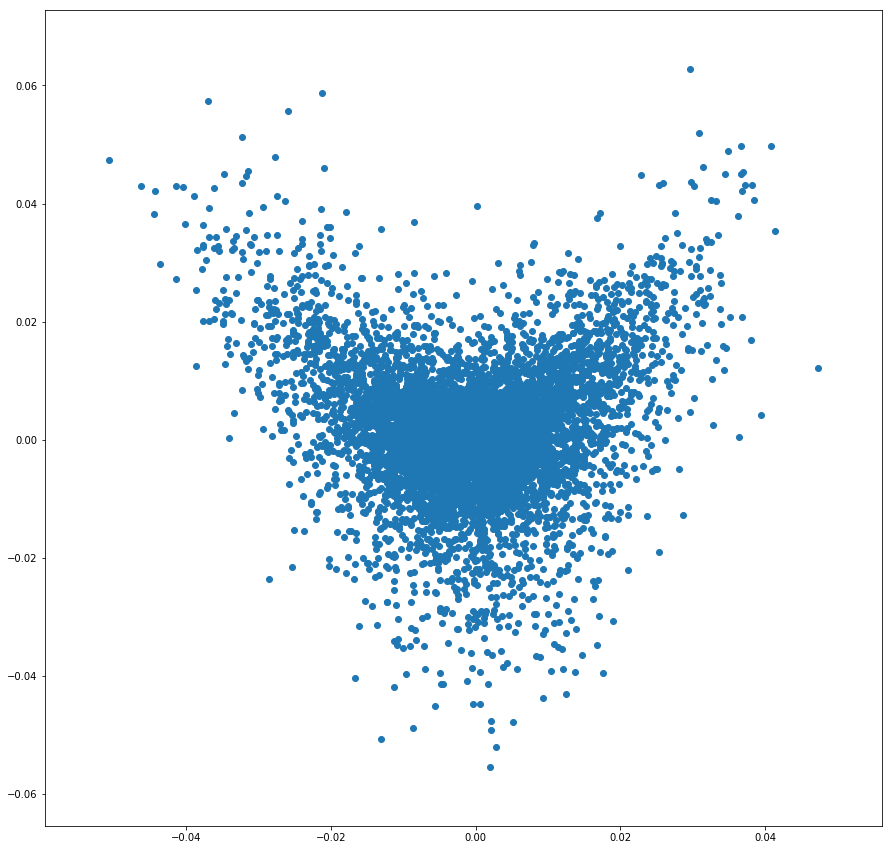

In [57]:
start=0; end=13500
X = fac20[start:end]
Y = fac21[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(allMovies[start:end], X, Y):
    plt.text(x,y,'', color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

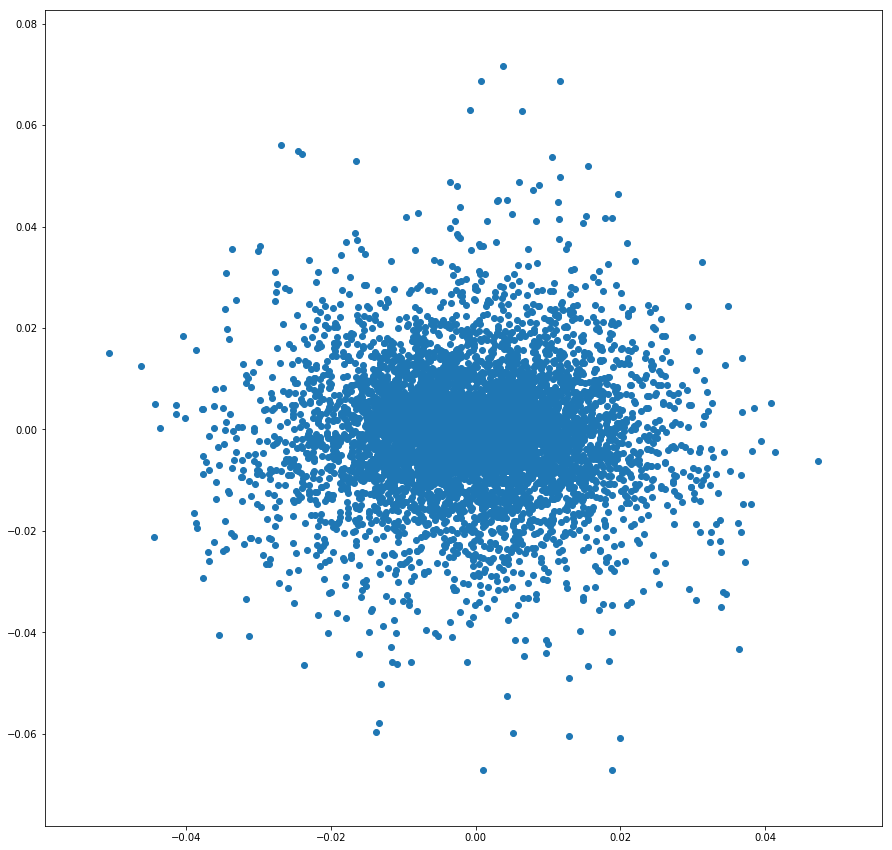

In [58]:
start=0; end=13500
X = fac20[start:end]
Y = fac22[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(allMovies[start:end], X, Y):
    plt.text(x,y,'', color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

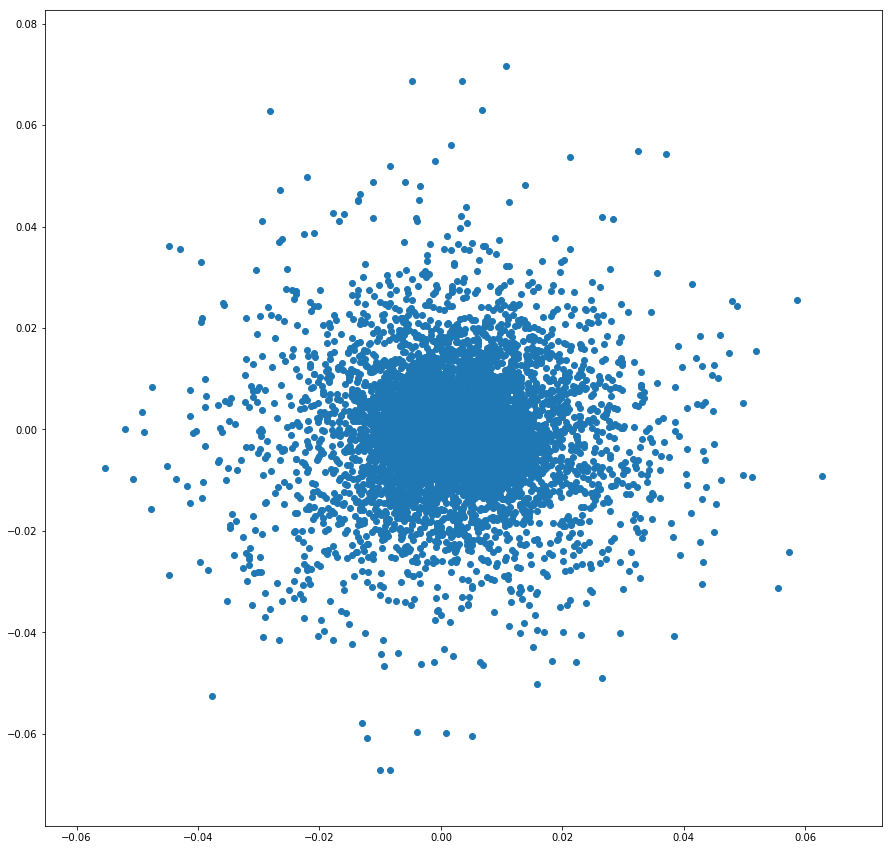

In [59]:
start=0; end=13500
X = fac21[start:end]
Y = fac22[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(allMovies[start:end], X, Y):
    plt.text(x,y,'', color=np.random.rand(3)*0.7, fontsize=14)
plt.show()